In [1]:
import os, re, configparser, math
import pandas as pd
import numpy as np
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_plotting import plot_scatter
from utilities_widgets import position_chart
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db

Database *input.db* found in: c:\Users\User\Desktop\Luciano\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\User\Desktop\Luciano\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    raise TypeError("Incorrect fixture data.")
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    INAMARSA_Measurements_2024y_03m_21d_11h_48m_04s
    INAMARSA_Limits_2024y_03m_21d_11h_48m_04s
    INAMARSA_FixtureData_2024y_05m_07d_13h_36m_25s


In [4]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('INAMARSA_Fixtu…

Table *INAMARSA_Measurements_2024y_03m_21d_11h_48m_04s* retrieved succesfully.
Table *INAMARSA_Limits_2024y_03m_21d_11h_48m_04s* retrieved succesfully.
Table *INAMARSA_FixtureData_2024y_05m_07d_13h_36m_25s* retrieved succesfully.


# Plot and tendency

,Ángulo de pendiente
Guia_Luz_Blanco_FB1_X,3.153846e-06
Guia_Luz_Blanco_FB1_Y,-2.307692e-06
Guia_Luz_Blanco_FB2_X,4.307692e-06
Guia_Luz_Blanco_FB2_Y,9.230770e-07
Guia_Luz_Blanco_FB3_X,-1.384615e-05
Guia_Luz_Blanco_FB3_Y,-1.461538e-06
Guia_Luz_Blanco_FB4_X,2.153846e-06
Guia_Luz_Blanco_FB4_Y,1.615385e-06
Guia_Luz_Blanco_FB5_X,4.307692e-06
Guia_Luz_Blanco_FB5_Y,1.384615e-06


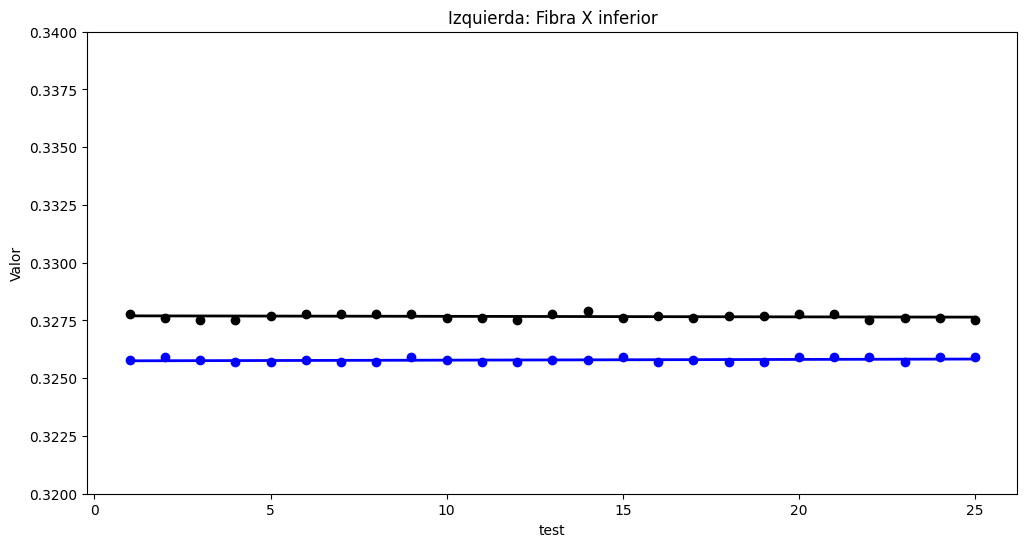

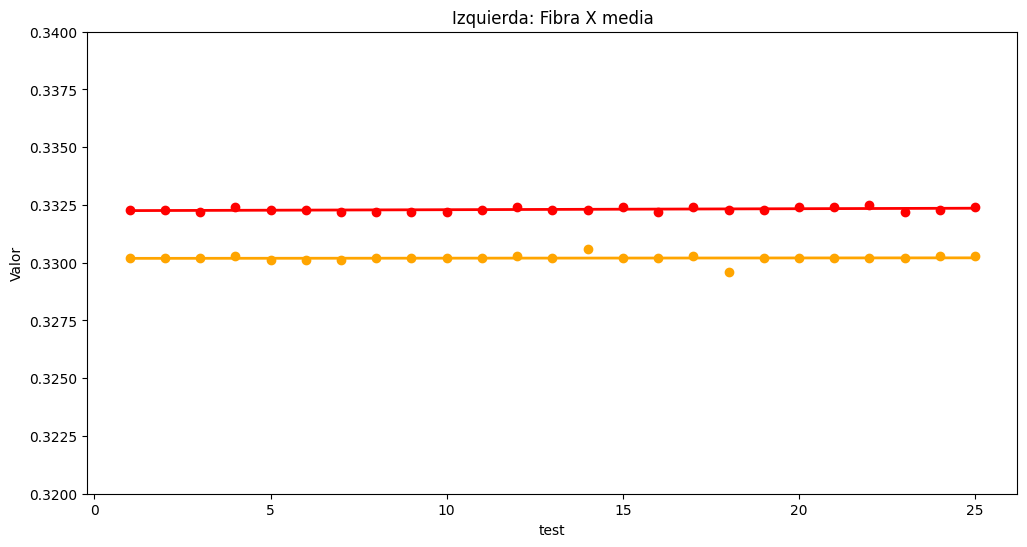

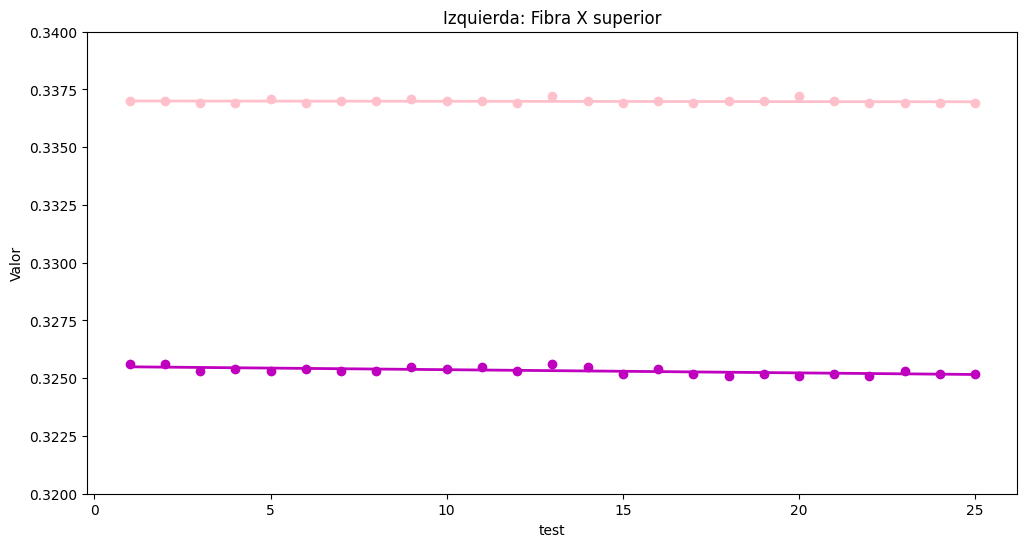

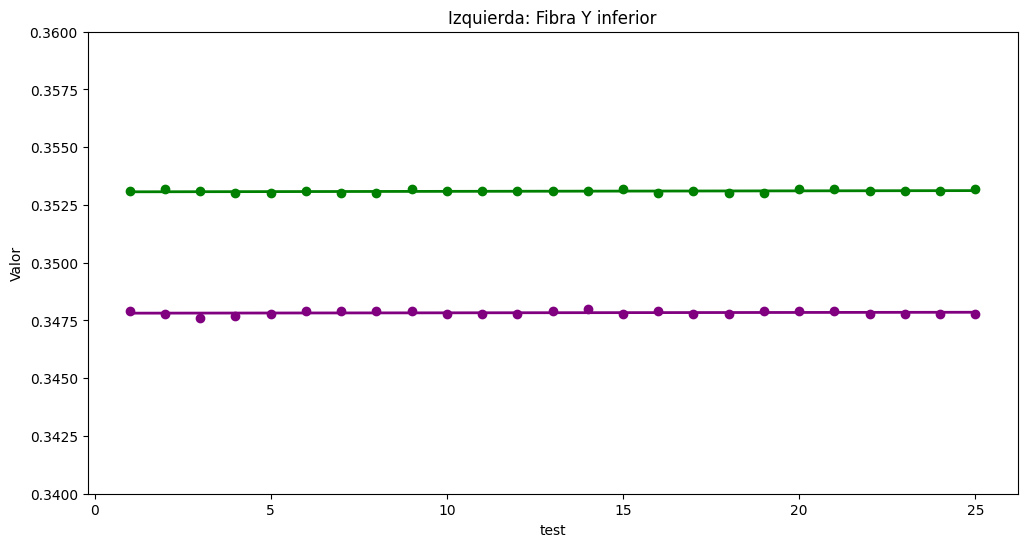

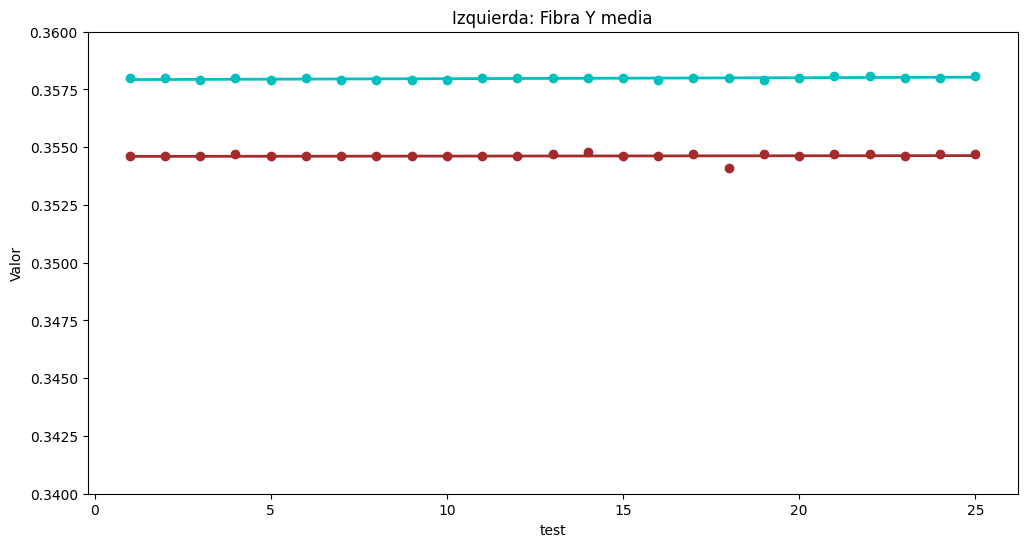

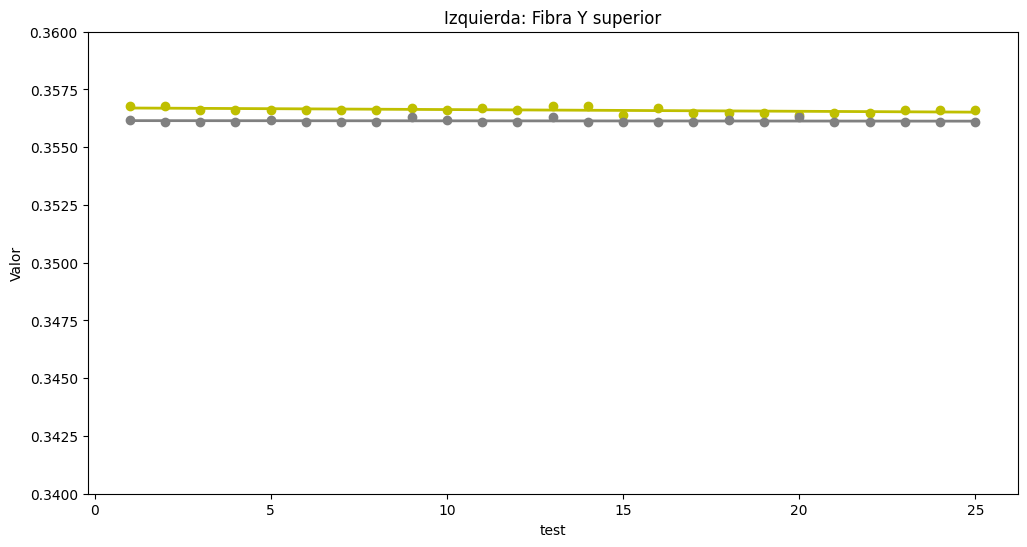

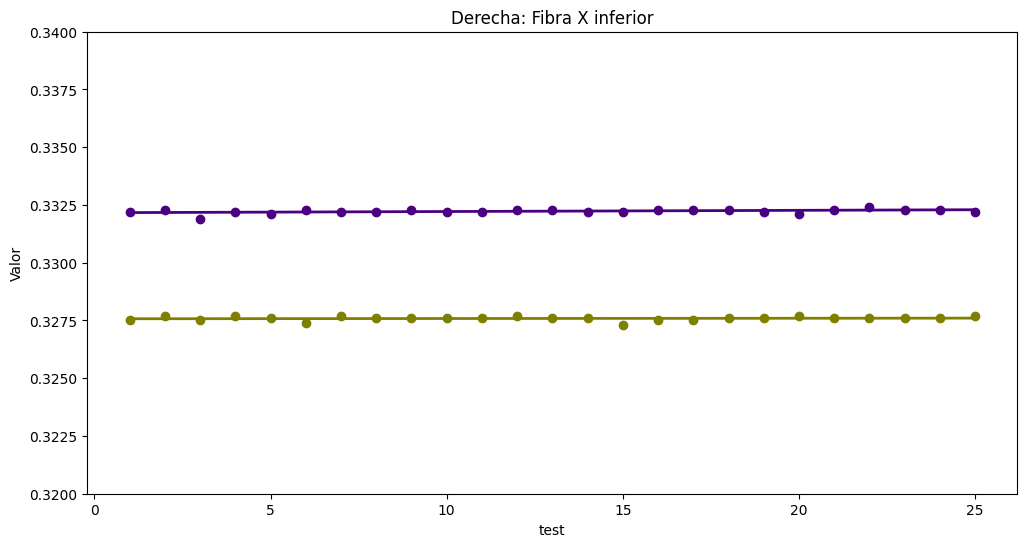

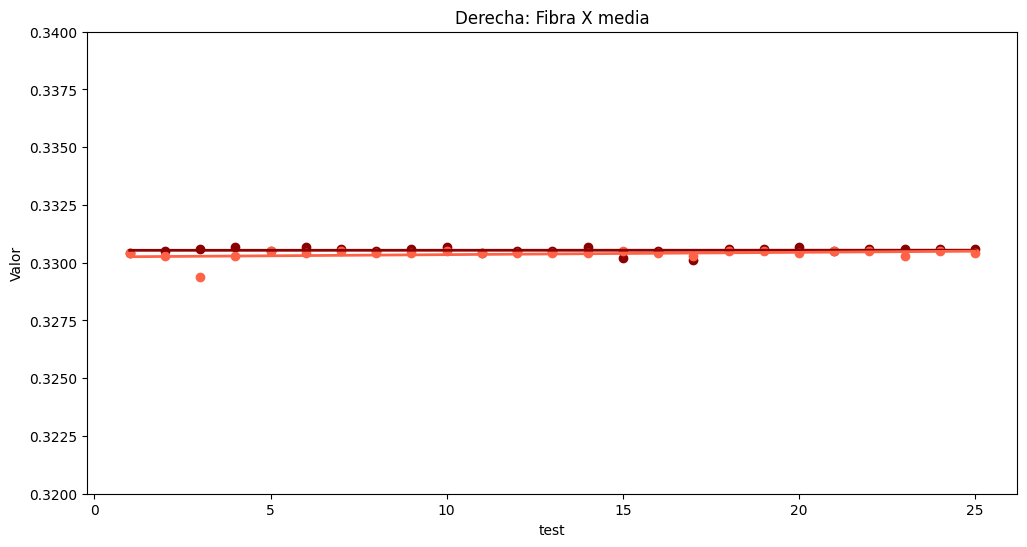

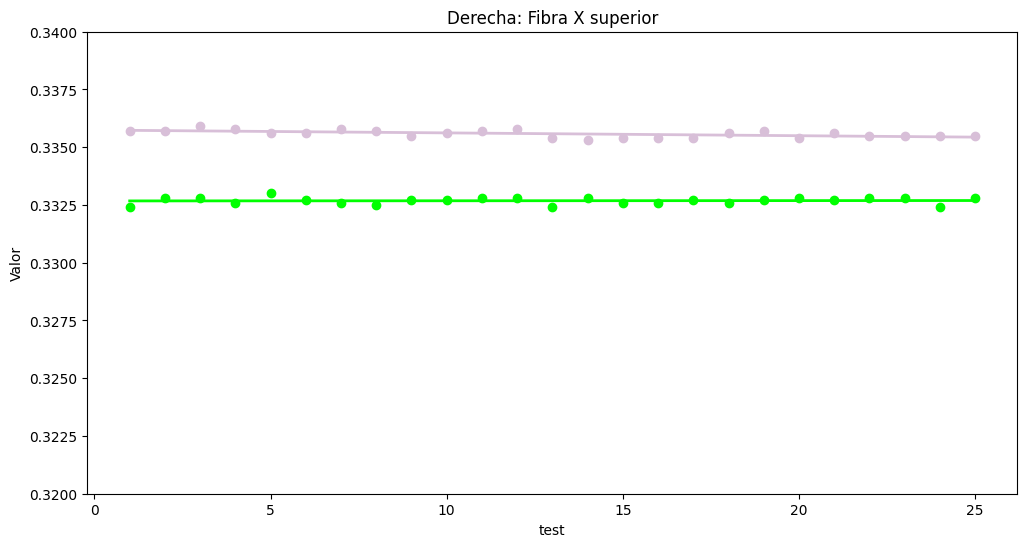

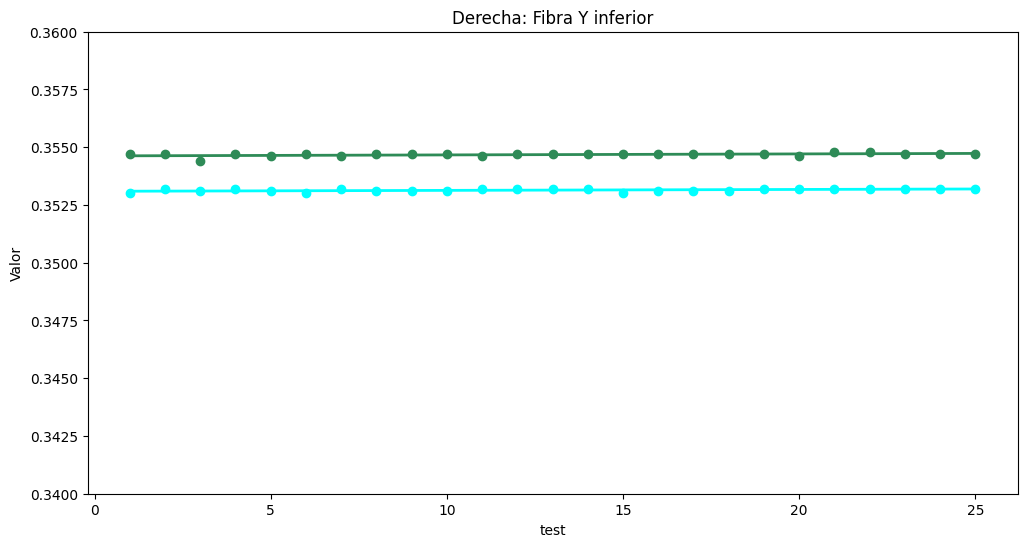

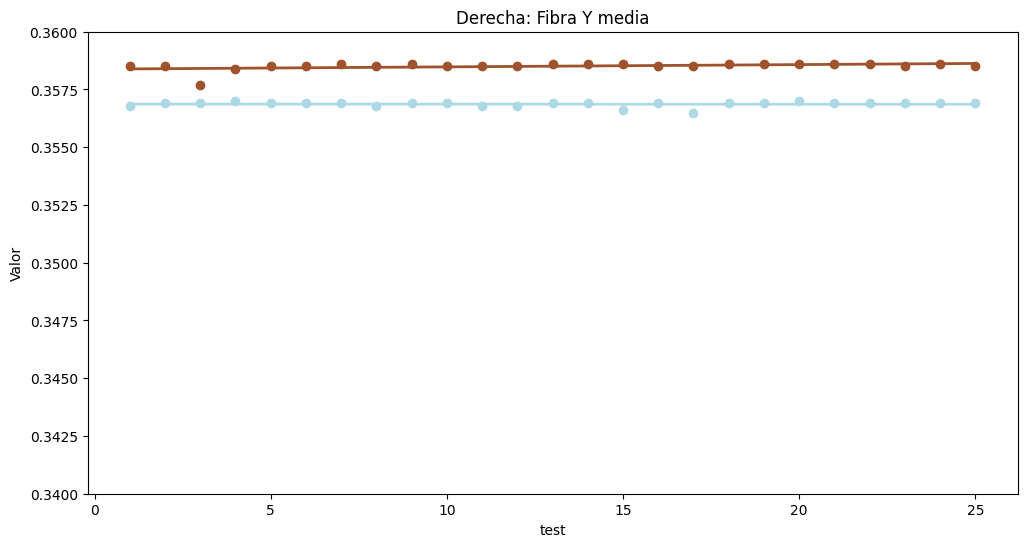

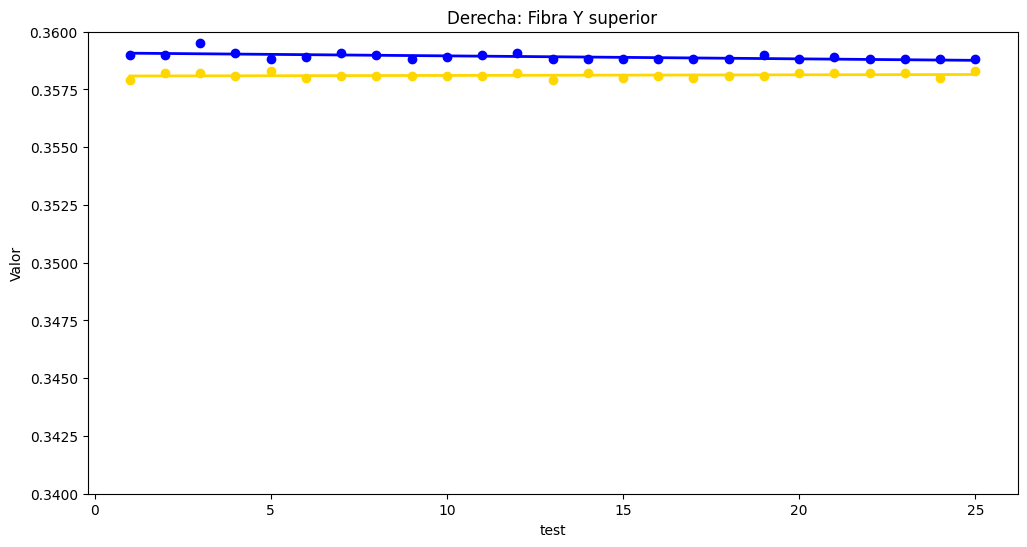

In [5]:
fibers = MEAS.to_numpy()
titles = ["Izquierda: Fibra X inferior", "Izquierda: Fibra X media", "Izquierda: Fibra X superior", "Izquierda: Fibra Y inferior", "Izquierda: Fibra Y media", "Izquierda: Fibra Y superior", 
          "Derecha: Fibra X inferior", "Derecha: Fibra X media", "Derecha: Fibra X superior", "Derecha: Fibra Y inferior", "Derecha: Fibra Y media", "Derecha: Fibra Y superior"]
yrange = [[0.32, 0.34], [0.32, 0.34], [0.32, 0.34], [0.34, 0.36], [0.34, 0.36], [0.34, 0.36],
         [0.32, 0.34], [0.32, 0.34], [0.32, 0.34], [0.34, 0.36], [0.34, 0.36], [0.34, 0.36]]
filter = [[1, 7], [3, 9], [5, 11], [2, 8], [4, 10], [6, 12], [13, 19], [15, 21], [17, 23], [14, 20], [16, 22], [18, 24]]
slopes_list = []
for i in range(int(fibers.shape[0]/2)):
    fig, slopes = plot_scatter(MEAS, title=titles[i], xlabel='test', ylabel='Valor', filter=filter[i], yrange=yrange[i], add_tendency=True) 
    slopes_list.append([round(math.atan(m), 12) for m in slopes][0])
    slopes_list.append([round(math.atan(m), 12) for m in slopes][1])    
slopes_list = pd.DataFrame(slopes_list, columns=["Ángulo de pendiente"])
slopes_list = rename_index(slopes_list)
display(slopes_list)

In [6]:
fiber_1x = fibers[0]
fiber_1y = fibers[1]
fiber_2x = fibers[2] 
fiber_2y = fibers[3]
fiber_3x = fibers[4]
fiber_3y = fibers[5]
fiber_4x = fibers[6]
fiber_4y = fibers[7]
fiber_5x = fibers[8]
fiber_5y = fibers[9]
fiber_6x = fibers[10]
fiber_6y = fibers[11]
fiber_7x = fibers[12]
fiber_7y = fibers[13]
fiber_8x = fibers[14]
fiber_8y = fibers[15]
fiber_9x = fibers[16]
fiber_9y = fibers[17]
fiber_10x = fibers[18]
fiber_10y = fibers[19]
fiber_11x = fibers[20]
fiber_11y = fibers[21]
fiber_12x = fibers[22]
fiber_12y = fibers[23]
differences_list = [
np.round(np.mean(np.absolute(fiber_1x - fiber_4x)), 4),
np.round(np.mean(np.absolute(fiber_2x - fiber_5x)), 4),
np.round(np.mean(np.absolute(fiber_3x - fiber_6x)), 4),
np.round(np.mean(np.absolute(fiber_1y - fiber_4y)), 4),
np.round(np.mean(np.absolute(fiber_2y - fiber_5y)), 4),
np.round(np.mean(np.absolute(fiber_3y - fiber_6y)), 4),
np.round(np.mean(np.absolute(fiber_7x - fiber_10x)), 4),
np.round(np.mean(np.absolute(fiber_8x - fiber_11x)), 4),
np.round(np.mean(np.absolute(fiber_9x - fiber_12x)), 4),
np.round(np.mean(np.absolute(fiber_7y - fiber_10y)), 4),
np.round(np.mean(np.absolute(fiber_8y - fiber_11y)), 4),
np.round(np.mean(np.absolute(fiber_9y - fiber_12y)), 4)
]

differences_list = pd.DataFrame(differences_list, columns=["Diferencias absolutas entre nidos"])
differences_list.index = titles
display(differences_list)


,Diferencias absolutas entre nidos
Izquierda: Fibra X inferior,0.0019
Izquierda: Fibra X media,0.0021
Izquierda: Fibra X superior,0.0117
Izquierda: Fibra Y inferior,0.0053
Izquierda: Fibra Y media,0.0034
Izquierda: Fibra Y superior,0.0005
Derecha: Fibra X inferior,0.0046
Derecha: Fibra X media,0.0002
Derecha: Fibra X superior,0.0029
Derecha: Fibra Y inferior,0.0015


In [7]:
##Measurements preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Correlation
print("Correlation Matrix:")
MEAS_format = MEAS_format.transpose()
MEAS_format.corr(method='pearson', min_periods=1, numeric_only=False)

Correlation Matrix:


,Guia_Luz_Blanco_FB1_X,Guia_Luz_Blanco_FB1_Y,Guia_Luz_Blanco_FB2_X,Guia_Luz_Blanco_FB2_Y,Guia_Luz_Blanco_FB3_X,Guia_Luz_Blanco_FB3_Y,Guia_Luz_Blanco_FB4_X,Guia_Luz_Blanco_FB4_Y,Guia_Luz_Blanco_FB5_X,Guia_Luz_Blanco_FB5_Y,...,Guia_Luz_Blanco_FB8_X,Guia_Luz_Blanco_FB8_Y,Guia_Luz_Blanco_FB9_X,Guia_Luz_Blanco_FB9_Y,Guia_Luz_Blanco_FB10_X,Guia_Luz_Blanco_FB10_Y,Guia_Luz_Blanco_FB11_X,Guia_Luz_Blanco_FB11_Y,Guia_Luz_Blanco_FB12_X,Guia_Luz_Blanco_FB12_Y
Guia_Luz_Blanco_FB1_X,1.000000,0.849694,0.401345,0.494136,-0.105996,-0.119161,-0.021785,0.042939,0.244521,0.292000,...,-0.039399,-0.032354,-0.010372,0.014484,0.129100,0.227793,0.013423,0.113096,-0.409317,-0.283480
Guia_Luz_Blanco_FB1_Y,0.849694,1.000000,0.334090,0.509478,0.046274,-0.045290,-0.058421,0.025190,0.286888,0.240741,...,-0.138675,-0.124423,0.184050,0.114708,0.075734,0.133631,-0.057745,0.066346,-0.330252,-0.200657
Guia_Luz_Blanco_FB2_X,0.401345,0.334090,1.000000,0.778639,-0.417820,-0.426295,-0.328329,-0.102578,0.152826,0.220973,...,-0.223259,-0.192325,0.172427,0.121305,0.262113,0.404966,0.255034,0.267515,-0.205273,-0.243652
Guia_Luz_Blanco_FB2_Y,0.494136,0.509478,0.778639,1.000000,-0.230470,-0.145709,-0.228622,-0.015931,0.122474,0.158114,...,-0.087706,-0.048015,0.051949,0.108821,0.431087,0.507093,0.209165,0.268709,-0.279101,-0.320743
Guia_Luz_Blanco_FB3_X,-0.105996,0.046274,-0.417820,-0.230470,1.000000,0.909656,0.277138,0.212434,0.285628,0.208232,...,0.003610,0.086948,-0.193842,-0.326439,0.020430,-0.055652,-0.105759,-0.068146,0.103379,0.159048
Guia_Luz_Blanco_FB3_Y,-0.119161,-0.045290,-0.426295,-0.145709,0.909656,1.000000,0.249260,0.235705,0.297428,0.194942,...,0.103219,0.192398,-0.186323,-0.180247,0.086387,-0.028418,-0.110522,-0.064306,0.053365,0.102590
Guia_Luz_Blanco_FB4_X,-0.021785,-0.058421,-0.328329,-0.228622,0.277138,0.249260,1.000000,0.849305,-0.042425,-0.016431,...,0.132157,0.139712,-0.272621,-0.278946,0.042083,0.114176,0.319833,0.406784,-0.301129,-0.282097
Guia_Luz_Blanco_FB4_Y,0.042939,0.025190,-0.102578,-0.015931,0.212434,0.235705,0.849305,1.000000,0.162598,0.176327,...,0.083836,0.059284,-0.226213,-0.213819,0.370444,0.457791,0.614091,0.702298,-0.476032,-0.512233
Guia_Luz_Blanco_FB5_X,0.244521,0.286888,0.152826,0.122474,0.285628,0.297428,-0.042425,0.162598,1.000000,0.903696,...,-0.017903,-0.098011,0.106040,0.098725,-0.079996,0.069007,-0.109789,-0.044473,-0.234588,0.031937
Guia_Luz_Blanco_FB5_Y,0.292000,0.240741,0.220973,0.158114,0.208232,0.194942,-0.016431,0.176327,0.903696,1.000000,...,-0.023113,-0.037959,0.063885,0.038236,-0.020655,0.133631,-0.031497,0.011483,-0.199017,0.004123


In [8]:
fiber_1x = pd.Series(fiber_1x)
fiber_1y = pd.Series(fiber_1y)
fiber_1x.corr(fiber_1y)

0.8496940710597275

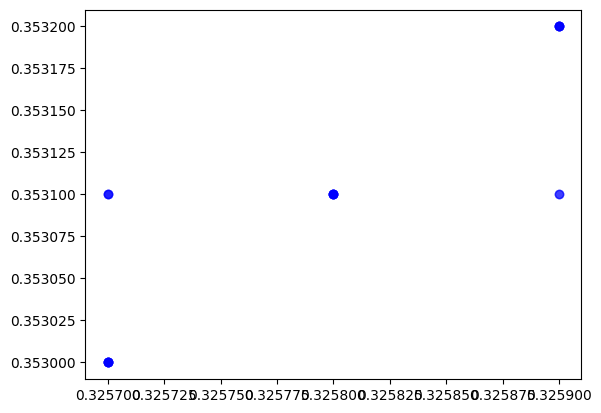

In [9]:
import matplotlib.pyplot as plt
plt.scatter(fiber_1x, fiber_1y, color='blue', alpha=0.5)  # Alpha controls transparency

# Bland-Altman Plot

References:
https://www.researchgate.net/publication/318482587_Decoding_the_Bland-Altman_plot_Basic_review

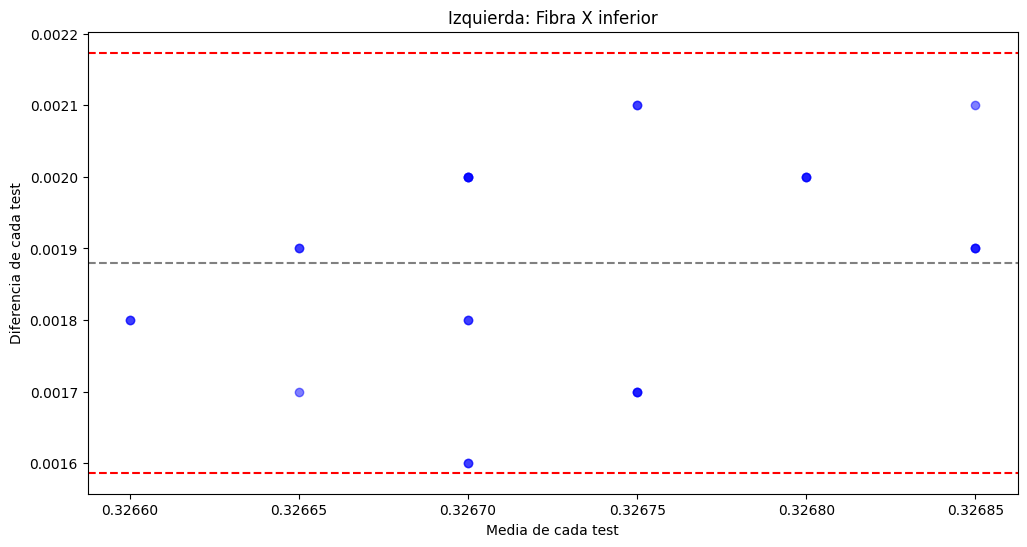

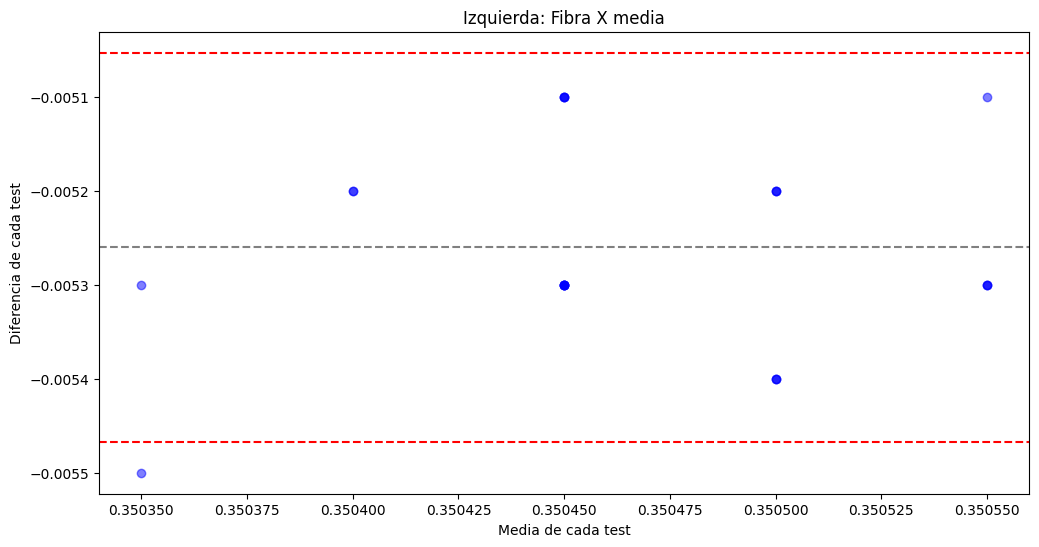

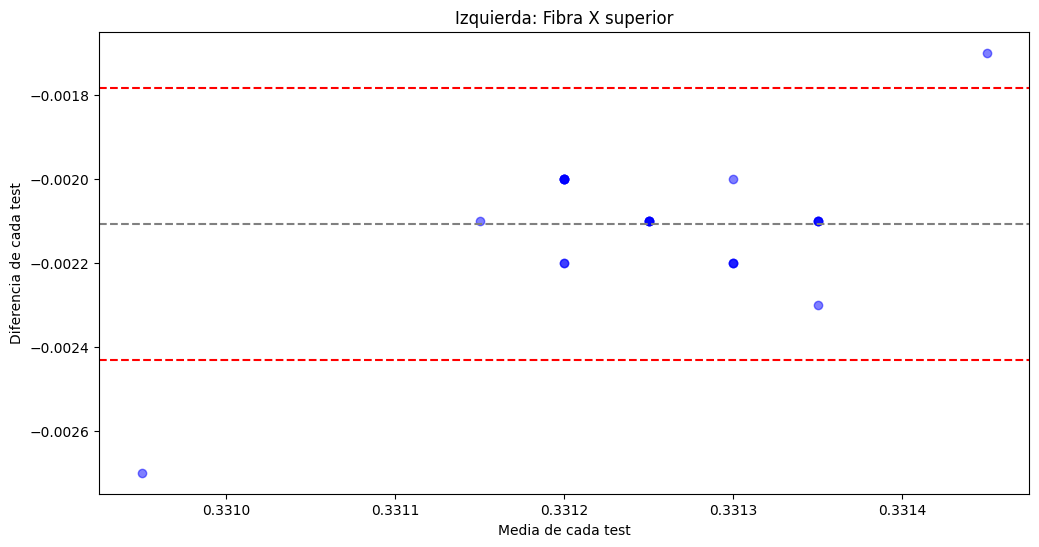

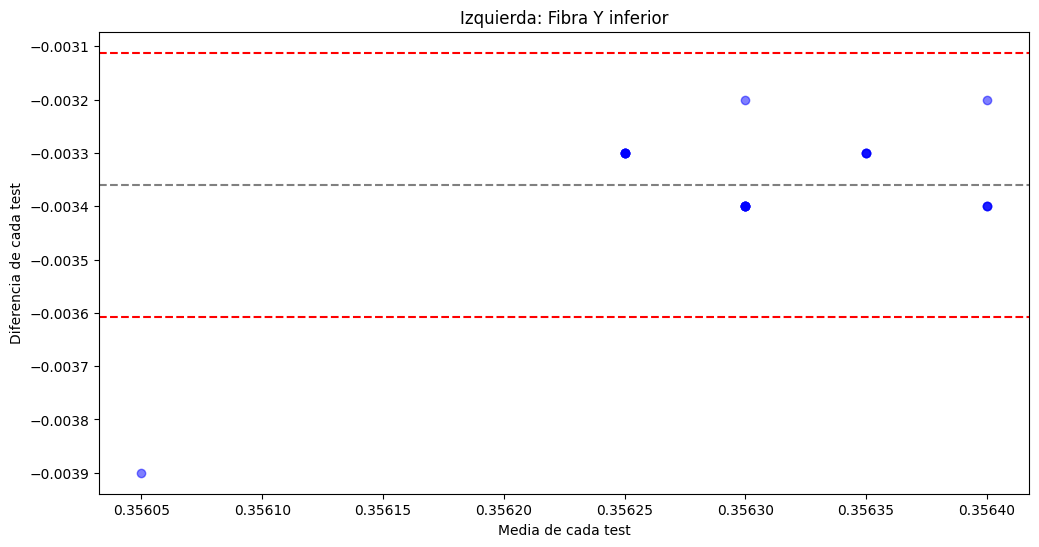

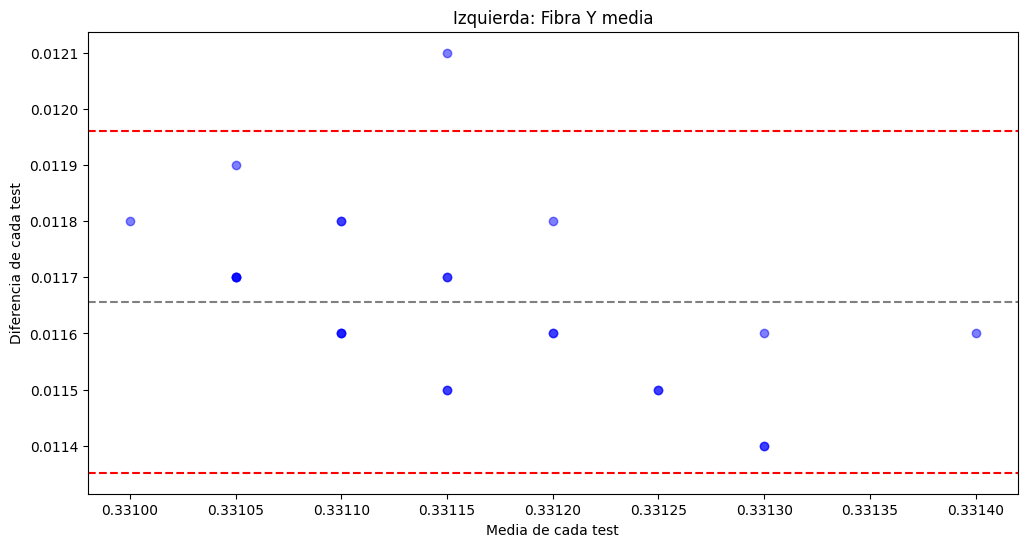

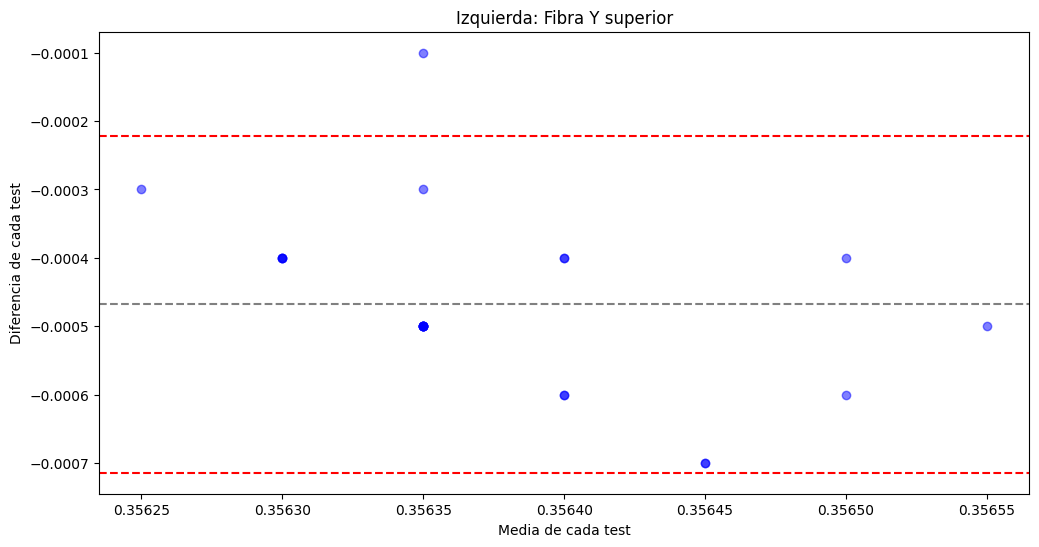

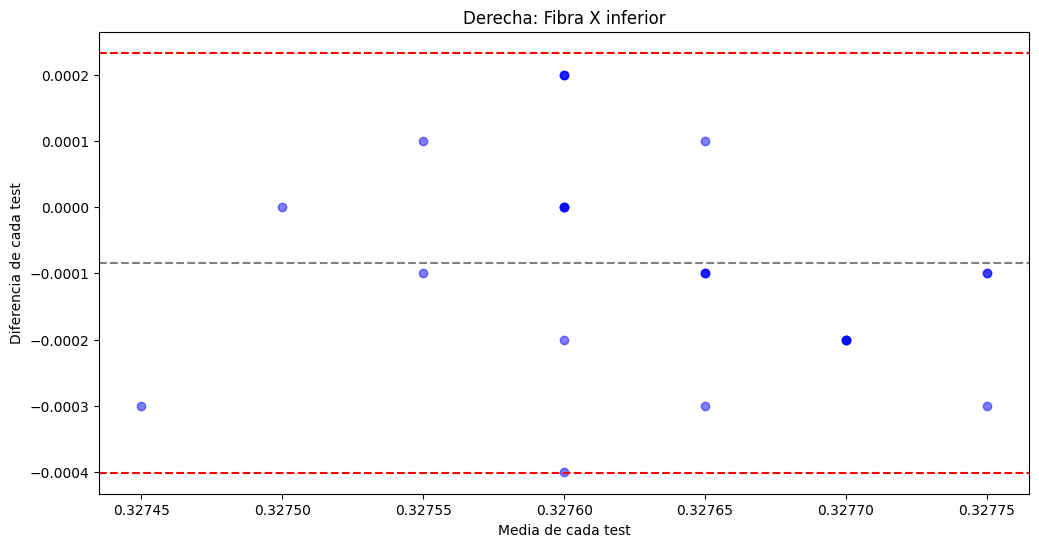

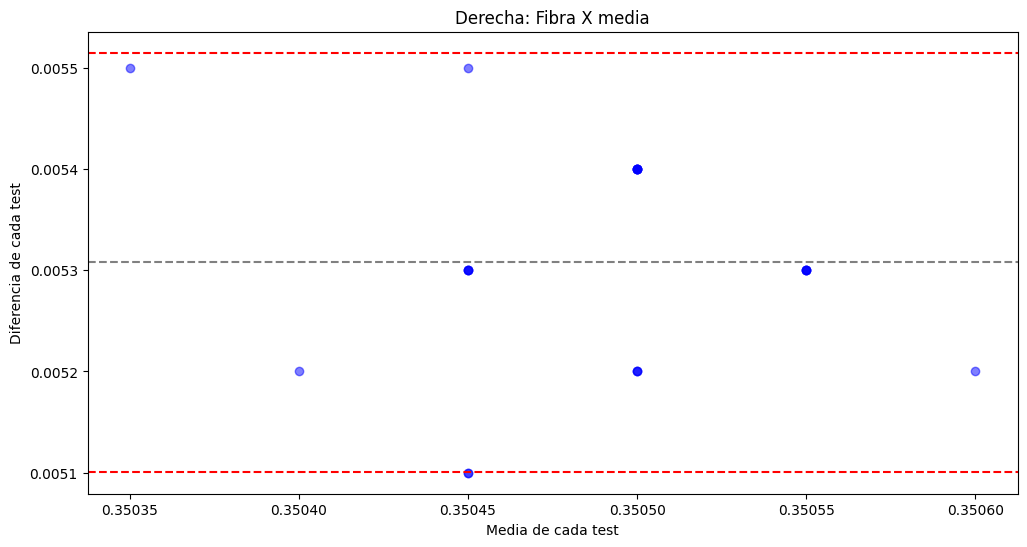

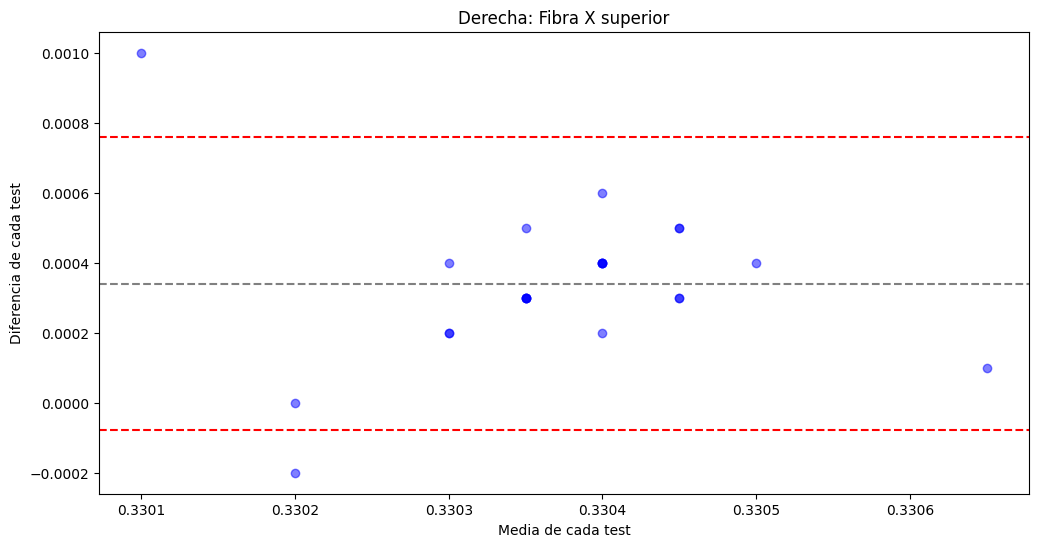

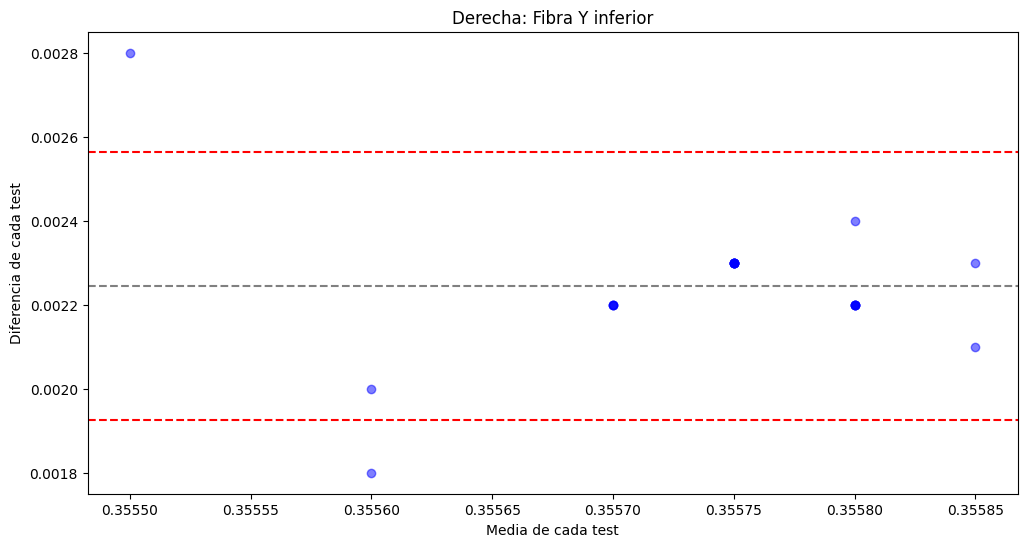

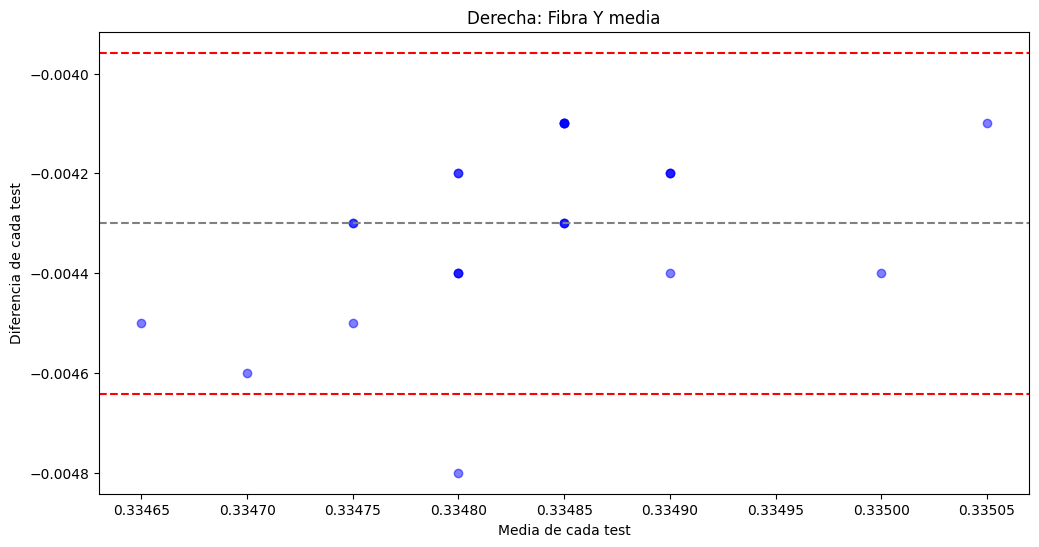

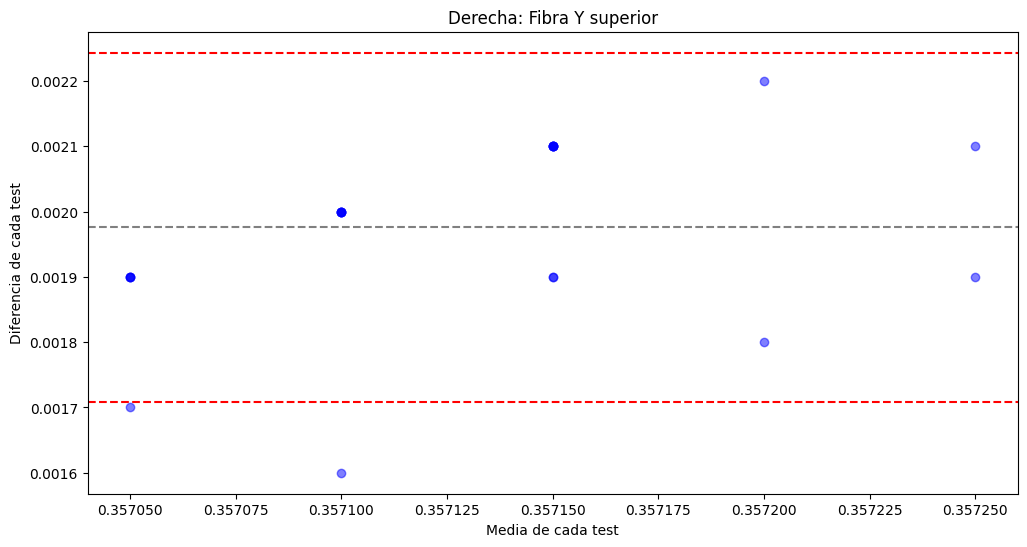

In [13]:
for i in range(int(fibers.shape[0]/2)):
    j = i + 6
    differences = [m2 - m1 for m1, m2 in zip(fibers[i], fibers[j])]
    average = [(m1 + m2) / 2 for m1, m2 in zip(fibers[i], fibers[j])]
    mean_difference = sum(differences) / len(differences)
    sd_difference = (sum((diff - mean_difference) ** 2 for diff in differences) / len(differences)) ** 0.5
    upper_limit = mean_difference + 1.96 * sd_difference
    lower_limit = mean_difference - 1.96 * sd_difference
    plt.subplots(figsize=(12, 6))
    plt.title(titles[i])
    plt.ylabel("Diferencia de cada test")
    plt.xlabel("Media de cada test")
    plt.axhline(y=mean_difference, color='gray', linestyle='--', label='Mean Difference')
    plt.axhline(y=upper_limit, color='red', linestyle='--', label='Upper Limit of Agreement')
    plt.axhline(y=lower_limit, color='red', linestyle='--', label='Lower Limit of Agreement')
    plt.scatter(average, differences, color='blue', alpha=0.5)
    plt.show()
